<a href="https://colab.research.google.com/github/tatsuya1407/atmaCup_8/blob/main/ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [103]:
!pip install texthero

In [104]:
import sys

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split

import lightgbm as lgb

from tqdm.auto import tqdm
from functools import partial

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import word2vec
from gensim.models import KeyedVectors

import texthero as hero
from texthero import preprocessing


## Read csv

In [105]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
display(train_df.head(),test_df.head())

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+


,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8,19.0,Io Interactive,M
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9,132.0,Crystal Dynamics,T
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M


In [106]:
# test_cols = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
#        'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
#        'Rating']

In [107]:
only_train_features = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]
only_train = train_df[only_train_features]

train = train_df.drop(only_train_features, axis=1)
test = test_df.copy()
assert(len(train.columns) == len(test.columns))

train['label'] = 'train'
test['label'] = 'test'

## preprocess

In [108]:
df = pd.concat([train, test])

seriesies = [
    "Pokemon", "LEGO", "Mario", "Nobunaga no Yabo", "Jikkyo Powerful"
]

def create_series(df) -> pd.DataFrame:
  df['Name'].fillna('unknown', inplace=True)
  df['series'] = -9999
  for i, series in enumerate(seriesies):
    df.loc[df['Name'].str.contains(series), "series"] = i
  df['series'] = df['series'].astype('category')

  return df

def preprocess(df) -> pd.DataFrame:
  def fill_null(df) -> pd.DataFrame:
    df['Year_of_Release'] = df['Year_of_Release'].fillna(-9999, inplace=True)
    df['Critic_Score'] = df['Critic_Score'].fillna(0, inplace=True)
    df['Critic_Count'] = df['Critic_Count'].fillna(0, inplace=True)
    df['User_Score'] = df['User_Score'].fillna(0, inplace=True)

    # 要検討
    df['User_Score'] = df['User_Score'].replace('tbd', 0)
    df['User_Score'] = df['User_Score'].astype(np.float)

    df['Developer'] = df['Developer'].fillna("unknown", inplace=True)
    df['Rating'] = df['Rating'].fillna("unknown", inplace=True)
    df['Publisher'] = df['Publisher'].fillna("unknown", inplace=True)
    df['Genre'] = df['Genre'].fillna("unknown", inplace=True)
    return df

  def transform_dtypes(df) -> pd.DataFrame:
    df[df.select_dtypes(object).columns] = df.select_dtypes(object).astype("category")
    return df

  def label_encode(df) -> pd.DataFrame:
    le = LabelEncoder()
    for col in df.select_dtypes("category"):
      if col == 'series':
        continue
      df[col] = le.fit_transform(df[col])
      df[col] = df[col].astype("category")

    return df

  def transform_scale(df) -> pd.DataFrame:
    df['User_Score'] = np.log1p(df['User_Score'])
    return df

  df = fill_null(df)
  df = transform_dtypes(df)
  df = label_encode(df)
  df = transform_scale(df)

  return df


df = create_series(df)
df = preprocess(df)
df

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,label,series
0,5128,26,0,0,0,0,0,NaN,22.0,0,0,1,1
1,5139,26,0,0,0,0,0,NaN,28.0,0,0,1,1
2,5128,19,0,0,0,0,0,NaN,10.0,0,0,1,1
3,1576,0,0,0,0,0,0,NaN,NaN,0,0,1,-9999
4,5137,26,0,0,0,0,0,NaN,13.0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,8207,20,0,0,0,0,0,NaN,NaN,0,0,0,-9999
8356,8207,18,0,0,0,0,0,NaN,NaN,0,0,0,-9999
8357,718,13,0,0,0,0,0,NaN,71.0,0,0,0,-9999
8358,1555,13,0,0,0,0,0,NaN,NaN,0,0,0,-9999


## LightGBM

In [109]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

In [197]:
fold_num = 7
EARLY_STOPPING_ROUNDS = 10
VERBOSE_EVAL = 100
LGB_ROUND_NUM = 10000


def plot_feature_importance(cols, lgb_model):
    attr = {k: v for k, v in zip(cols, lgb_model.feature_importance()) if v > 0}
    attr = sorted(attr.items(), key=lambda x: x[1], reverse=False)
    x1, y1 = zip(*attr)
    i1 = range(len(x1))
    plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
    plt.barh(i1, y1)
    plt.title("LGBM importance")
    plt.yticks(i1, x1)
    plt.show()

def fit_lgb(x, y, cv, params: dict=None, verbose: int = 10):
  if params is None:
    params = {}
  
  models = []
  oof_pred = np.zeros_like(y, dtype=np.float)

  for idx, (idx_train, idx_valid) in enumerate(cv):
    x_train, y_train = x.iloc[idx_train], y.iloc[idx_train]
    x_valid, y_valid = x.iloc[idx_valid], y.iloc[idx_valid]

    clf = lgb.LGBMRegressor(**params)
    print(f'Fold {idx} start:\n')
    clf.fit(x_train, y_train, 
          eval_set = [(x_valid, y_valid)],
          early_stopping_rounds = EARLY_STOPPING_ROUNDS,
          verbose = VERBOSE_EVAL
          )
    
    pred_i = clf.predict(x_valid)
    
    pred_i = np.where(pred_i < 0, 0, pred_i)
    oof_pred[idx_valid] = pred_i
    models.append(clf)

    print(f'Fold {idx} end\n')

  score = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(oof_pred)))
  print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
  
  return oof_pred, models

In [198]:
label_train = df[df['label'] == 1]
label_test = df[df['label'] == 0]

x = label_train.drop(['label'], axis=1)
y = np.log1p(only_train['Global_Sales'])

x_test = label_test.drop(['label'], axis=1)
skf = StratifiedKFold(n_splits=fold_num, random_state= 40)
cv = list(skf.split(x, x['Publisher']))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [ ]:
oof, models = fit_lgb(x, y, cv, params)

In [216]:
pred_sales = np.expm1(oof)
pd.DataFrame({'pred': pred_sales})

,pred
0,77.913233
1,121.214566
2,42.305031
3,36.069755
4,90.512997
...,...
8354,17.825818
8355,1.651216
8356,7.266422
8357,10.702542


In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax
fig, ax = visualize_importance(models, x)

In [229]:
pred = np.array([model.predict(x_test.values) for model in models])
pred = np.mean(np.expm1(pred), axis=0)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join('simple_submission.csv'), index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



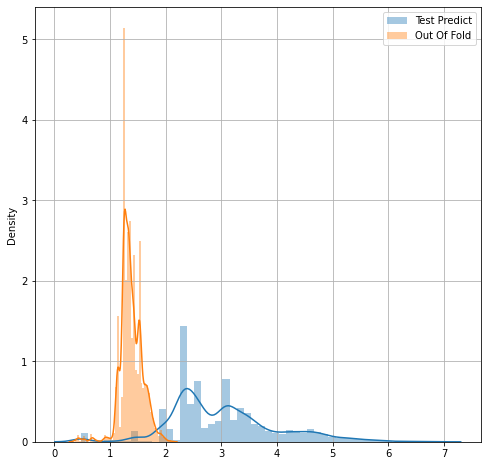

In [230]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(np.log1p(oof), label='Out Of Fold')
ax.legend()
ax.grid()